# ***LSTM网络生成爵士乐***

# 0. 要解决的问题

① 在本次作业中，你将使用LSTM实现乐曲生成模型。你可以在作业结束时试听自己创作的音乐。

② 你将学习：

 - 将LSTM应用于音乐生成。
 - 通过深度学习生成自己的爵士乐曲。

① 你想专门为朋友的生日创作一首爵士乐曲。

② 但是，你不了解任何乐器或音乐作品。

③ 幸运的是，你懂得深度学习并且可以使用LSTM网络来尝试解决此问题。

④ 你将训练一个网络，根据已表演作品的风格生成新颖的爵士小歌。

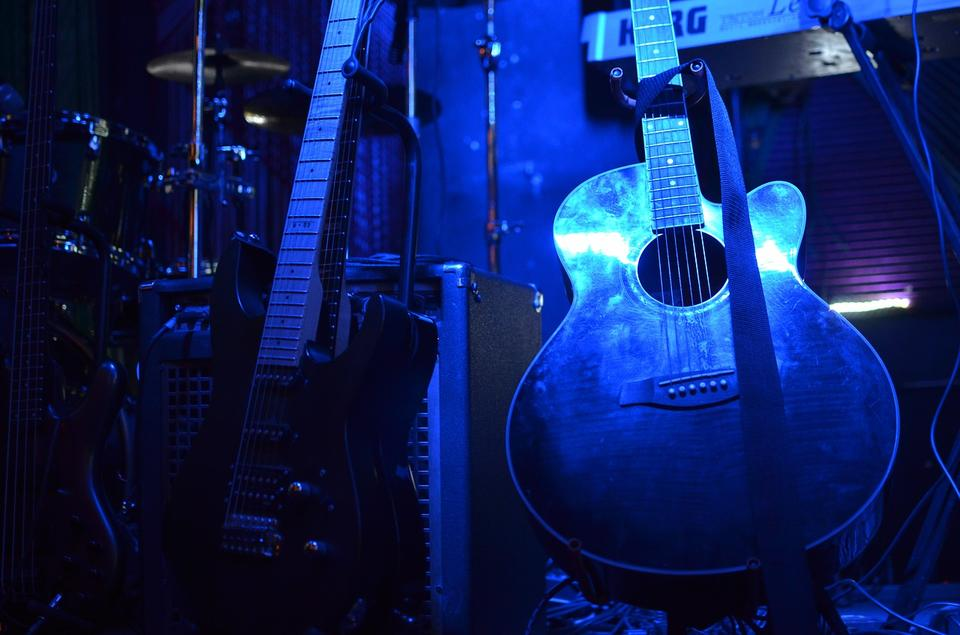

# 1. 导入库

In [1]:
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import IPython
import sys
from music21 import *
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *

Using TensorFlow backend.
D:\11_Anaconda\envs\py3.6.3\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# 2. 数据集

① 你将在爵士乐曲语料库上训练算法。

② 运行下面的单元格以试听训练集中的音频片段。

In [2]:
IPython.display.Audio('./datasets/30s_seq.mp3')

① 我们已经对音乐数据进行了预处理，以根据音乐“value”呈现音乐数据。

② 你可以将每个“值”视为一个音符，其中包括一个音调和一个持续时间。例如，如果你按下特定的钢琴键0.5秒钟，则你刚刚演奏了一个音符。

③ 在音乐理论中，“值”实际上比这复杂得多。具体来说，它还捕获同时演奏多个音符所需的信息。

④ 例如，演奏音乐作品时，你可以同时按下两个钢琴键（同时演奏多个音符会产生所谓的“和弦”）。

⑤ 但是我们不需要讨论音乐理论的过多细节。

⑥ 出于此作业的目的，你需要知道的是，我们将获取值的数据集，并将学习RNN模型以生成值序列。

⑦ 我们的音乐生成系统将使用78个唯一值。

⑧ 运行以下代码以加载原始音乐数据并将其预处理为值。这可能需要几分钟。

In [3]:
X, Y, n_values, indices_values = load_music_utils()
print('shape of X:', X.shape)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('Shape of Y:', Y.shape)

shape of X: (60, 30, 78)
number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 78
Shape of Y: (30, 60, 78)


① 你刚刚加载了以下内容：

 - X：这是维度为(m, $T_x$, 78)的数组。
   - 我们有m个训练示例，每个训练示例都是$T_x =30$音乐值的摘要。
   - 在每个时间步，输入都是78个不同的可能值之一，表示为独热向量。
   - 因此，例如，X[i,t,:]是一个独热向量，表示在时间t处第i个示例的值。

 - Y：本质上与X相同，但是向左（过去）移了一步。
   - 与恐龙作业相似，我们对使用先前值预测下一个值的网络感兴趣，因此，给定$x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$时，我们的序列模型将尝试预测$y^{\langle t \rangle}$。
   - 然而，“Y”中的数据被重新排序为$(T_y, m, 78)$的维度，其中$T_y = T_x$，以方便之后输入到LSTM。

 - n_values：该数据集中不同值的数量。即78。

 - indices_values：python字典，映射为0-77的音乐值。

# 3. 搭建模型

① 这是我们将使用的模型结构，架构如下所示。

② 这与你在上一个笔记本中使用的Dinosaurus模型相似，不同之处在于你将用Keras实现它。

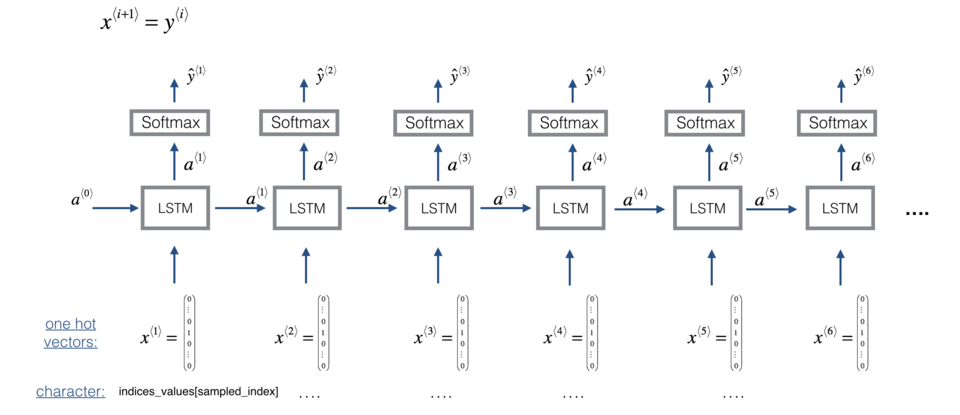

③ 我们将在更长的音乐片段中随机抽取30个值的片段来训练模型。

④ 因此不必费心设置第一个输入$x^{\langle 1 \rangle} = \vec{0}$，因为现在大部分代码段都用它来表示恐龙名称的开头。

⑤ 音频开始于一段音乐的中间。

⑥ 我们将每个片段设置为相同的长度$T_x = 30$，使得向量化更加容易。

① 在这一部分中，你将构建和训练一个音乐学习模型。

② 为此，你将需要构建一个模型，该模型采用维度为$(m, T_x, 78)$的X和维度为$(T_y, m, 78)$的Y。

③ 我们将使用具有64维隐藏状态的LSTM，设置n_a = 64。

① 函数djmodel()将使用for循环调用LSTM层$T_x$次，并且所有$T_x$副本都具有相同的权重。
 - 即不应该每次都重新初始化权重，$T_x$步应该具有共享的权重。
 
② 在Keras中实现可共享权重的网络层的关键步骤是：

 1. 定义层对象（为此，我们将使用全局变量）。
 2. 在传播输入时调用这些对象。

③ 我们已经将你需要的层对象定义为全局变量。请运行下一个单元格以创建它们。查看Keras文档以确保你了解这些层是什么。

In [4]:
n_a = 64
reshapor = Reshape((1, 78))                       #2.B
LSTM_cell = LSTM(n_a, return_state = True)        #2.C
densor = Dense(n_values, activation='softmax')    #2.D

④ 现在，reshapor, LSTM_cell 和 densor 都是层对象，你可以使用它们来实现 djmodel()。

⑤ 为了通过这些层传播Keras张量对象X，使用layer_object(X)（如果需要多个输入，则使用layer_object([X,Y])）。

⑥ 例如，reshapor(X)将通过上面定义的Reshape((1,78))层传播X。

① 练习：实现djmodel()，你需要执行2个步骤：

 1. 创建一个空列表“输出”在每个时间步保存的LSTM单元的输出。
 2. 循环$t \in 1, \ldots, T_x$：
    
    A. 从X选择第“t”个时间步向量。选择的维度应为（78，）。为此，请使用以下代码行在Keras中创建自定义Lambda 层：
      - x = Lambda(lambda x: X[:,t,:])(X)
      - 查看Keras文档以了解其作用。它正在创建一个“临时”或“未命名”函数（Lambda函数就是该函数），以提取适当的独热向量，并将该函数作为Keras的Layer对象应用于X。
      
    B. 将x重塑为（1,78）。你可能会发现reshapor()层（在下面定义）很有用。
    
    C. 运行x通过LSTM_cell的一个步骤。记住要使用上一步的隐藏状态$a$和单元状态$c$
初始化LSTM_cell。使用以下格式：
       - a, \_, c = LSTM_cell(input_x, initial_state=[previous hidden state, previous cell state])
       
    D. 使用“densor”通过dense+softmax层传播LSTM输出的激活值。
    
    E. 将预测值添加到"outputs"列表中

In [5]:
def djmodel(Tx, n_a, n_values):
    """
    实现这个模型
    
    参数：
        Tx -- 语料库的长度
        n_a -- 激活值的数量
        n_values -- 音乐数据中唯一数据的数量
        
    返回：
        model -- Keras模型实体
    """
    # 定义输入数据的维度
    X = Input((Tx, n_values))
    
    # 定义a0, 初始化隐藏状态
    a0 = Input(shape=(n_a,),name="a0")
    c0 = Input(shape=(n_a,),name="c0")
    a = a0
    c = c0
    
    # 第一步：创建一个空的outputs列表来保存LSTM的所有时间步的输出。
    outputs = []
    
    # 第二步：循环
    for t in range(Tx):
        ## 2.A：从X中选择第“t”个时间步向量
        x = Lambda(lambda x:X[:, t, :])(X)
        
        ## 2.B：使用reshapor来对x进行重构为(1, n_values)
        x = reshapor(x)
        
        ## 2.C：单步传播
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        ## 2.D：使用densor()应用于LSTM_Cell的隐藏状态输出
        out = densor(a)
        
        ## 2.E：把预测值添加到"outputs"列表中
        outputs.append(out)
        
    # 第三步：创建模型实体
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

② 运行以下单元格以定义模型。我们将使用Tx=30, n_a=64（LSTM激活的维数）和n_values=78。

③ 该单元可能需要几秒钟才能运行。

In [6]:
# 获取模型，这里Tx=30, n_a=64，n_values=78
model = djmodel(Tx = 30 , n_a = 64, n_values = 78)

④ 现在，你需要编译模型以进行训练。我们将使用Adam优化器和交叉熵熵损失。

In [7]:
# 编译模型，我们使用Adam优化器与分类熵损失。
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

⑤ 最后，将LSTM的初始状态a0和c0初始化为零。

In [8]:
# 初始化a0和c0，使LSTM的初始状态为零。
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

① 现在让我们拟合模型！

② 由于损失函数希望以每个时间步一个列表项的格式提供“Y”，因此我们需要将“Y”转换为列表。

③ list(Y)是一个包含30个项的列表，其中每个列表项的维度均为（60,78）。

④ 让我们训练100个epoch。这将需要几分钟。

In [9]:
import time

#开始时间
start_time = time.clock()

#开始拟合
model.fit([X, a0, c0], list(Y), epochs=100)

#结束时间
end_time = time.clock()

#计算时差
minium = end_time - start_time

print("执行了：" + str(int(minium / 60)) + "分" + str(int(minium%60)) + "秒")

Epoch 1/100
60/60 [==============================] - 11s 188ms/step - loss: 125.7255 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0000e+00 - dense_1_acc_1: 0.0000e+00 - dense_1_acc_2: 0.1167 - dense_1_acc_3: 0.0333 - dense_1_acc_4: 0.0333 - dense_1_acc_5: 0.0833 - dense_1_acc_6: 0.0667 - dense_1_acc_7: 0.0167 - dense_1_acc_8: 0.0333 - dense_1_acc_9: 0.0667 - dense_1_acc_10: 0.0167 - dense_1_acc_11: 0.0333 - dense_1_acc_12: 0.0500 - dense_1_acc_13: 0.1167 - dense_1_acc_14: 0.1000 - dense_1_acc_15: 0.0500 - dense_1_acc_16: 0.0667 - dense_1_acc_17: 0.0333 - dense_1_acc_18: 0.0500 - dense_1_acc_19: 0.0167 - dense_1_acc_20: 0.0500 - dense_1_acc_21: 0.0167 - dense_1_acc_22: 0.0833 - dense_1_acc_23: 0.0167 - dense_1_acc_24: 0.0333 - dense_1_acc_25: 0.0667 - dense_1_acc_26: 0.0500 - dense_1_acc_27: 0.0500 - dense_1_acc_28: 0.0833 - dense_1_acc_29: 0.0000e+00                                                                 
Epoch 2/100
60/60 [==============================] - 0s 781us/step - loss

60/60 [==============================] - 0s 765us/step - loss: 61.9908 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.1667 - dense_1_acc_2: 0.3333 - dense_1_acc_3: 0.3000 - dense_1_acc_4: 0.3167 - dense_1_acc_5: 0.4333 - dense_1_acc_6: 0.3833 - dense_1_acc_7: 0.4167 - dense_1_acc_8: 0.4667 - dense_1_acc_9: 0.5500 - dense_1_acc_10: 0.4167 - dense_1_acc_11: 0.4500 - dense_1_acc_12: 0.4833 - dense_1_acc_13: 0.4667 - dense_1_acc_14: 0.3833 - dense_1_acc_15: 0.3167 - dense_1_acc_16: 0.4500 - dense_1_acc_17: 0.4333 - dense_1_acc_18: 0.5000 - dense_1_acc_19: 0.5000 - dense_1_acc_20: 0.5667 - dense_1_acc_21: 0.4833 - dense_1_acc_22: 0.4667 - dense_1_acc_23: 0.5167 - dense_1_acc_24: 0.5000 - dense_1_acc_25: 0.6000 - dense_1_acc_26: 0.5000 - dense_1_acc_27: 0.5167 - dense_1_acc_28: 0.4833 - dense_1_acc_29: 0.0000e+00
Epoch 20/100
60/60 [==============================] - 0s 790us/step - loss: 59.0314 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.1667 - d

60/60 [==============================] - 0s 848us/step - loss: 23.0691 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.4000 - dense_1_acc_2: 0.7000 - dense_1_acc_3: 0.7333 - dense_1_acc_4: 0.8167 - dense_1_acc_5: 0.9000 - dense_1_acc_6: 0.9167 - dense_1_acc_7: 0.9500 - dense_1_acc_8: 0.9333 - dense_1_acc_9: 0.9833 - dense_1_acc_10: 1.0000 - dense_1_acc_11: 0.9833 - dense_1_acc_12: 0.9833 - dense_1_acc_13: 1.0000 - dense_1_acc_14: 1.0000 - dense_1_acc_15: 1.0000 - dense_1_acc_16: 1.0000 - dense_1_acc_17: 1.0000 - dense_1_acc_18: 1.0000 - dense_1_acc_19: 1.0000 - dense_1_acc_20: 1.0000 - dense_1_acc_21: 1.0000 - dense_1_acc_22: 0.9833 - dense_1_acc_23: 1.0000 - dense_1_acc_24: 1.0000 - dense_1_acc_25: 0.9833 - dense_1_acc_26: 1.0000 - dense_1_acc_27: 0.9833 - dense_1_acc_28: 0.9333 - dense_1_acc_29: 0.0000e+00
Epoch 38/100
60/60 [==============================] - 0s 781us/step - loss: 21.7658 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.4000 - d

60/60 [==============================] - 0s 765us/step - loss: 10.4101 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.5167 - dense_1_acc_2: 0.7833 - dense_1_acc_3: 0.9500 - dense_1_acc_4: 0.9667 - dense_1_acc_5: 1.0000 - dense_1_acc_6: 1.0000 - dense_1_acc_7: 1.0000 - dense_1_acc_8: 1.0000 - dense_1_acc_9: 1.0000 - dense_1_acc_10: 1.0000 - dense_1_acc_11: 1.0000 - dense_1_acc_12: 1.0000 - dense_1_acc_13: 1.0000 - dense_1_acc_14: 1.0000 - dense_1_acc_15: 1.0000 - dense_1_acc_16: 1.0000 - dense_1_acc_17: 1.0000 - dense_1_acc_18: 1.0000 - dense_1_acc_19: 1.0000 - dense_1_acc_20: 1.0000 - dense_1_acc_21: 1.0000 - dense_1_acc_22: 1.0000 - dense_1_acc_23: 1.0000 - dense_1_acc_24: 1.0000 - dense_1_acc_25: 1.0000 - dense_1_acc_26: 1.0000 - dense_1_acc_27: 1.0000 - dense_1_acc_28: 0.9833 - dense_1_acc_29: 0.0000e+00
Epoch 56/100
60/60 [==============================] - 0s 782us/step - loss: 10.1212 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.5167 - d

60/60 [==============================] - 0s 773us/step - loss: 7.4416 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.6000 - dense_1_acc_2: 0.8667 - dense_1_acc_3: 0.9833 - dense_1_acc_4: 1.0000 - dense_1_acc_5: 1.0000 - dense_1_acc_6: 1.0000 - dense_1_acc_7: 1.0000 - dense_1_acc_8: 1.0000 - dense_1_acc_9: 1.0000 - dense_1_acc_10: 1.0000 - dense_1_acc_11: 1.0000 - dense_1_acc_12: 1.0000 - dense_1_acc_13: 1.0000 - dense_1_acc_14: 1.0000 - dense_1_acc_15: 1.0000 - dense_1_acc_16: 1.0000 - dense_1_acc_17: 1.0000 - dense_1_acc_18: 1.0000 - dense_1_acc_19: 1.0000 - dense_1_acc_20: 1.0000 - dense_1_acc_21: 1.0000 - dense_1_acc_22: 1.0000 - dense_1_acc_23: 1.0000 - dense_1_acc_24: 1.0000 - dense_1_acc_25: 1.0000 - dense_1_acc_26: 1.0000 - dense_1_acc_27: 1.0000 - dense_1_acc_28: 1.0000 - dense_1_acc_29: 0.0000e+00
Epoch 74/100
60/60 [==============================] - 0s 765us/step - loss: 7.3525 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.6000 - den

60/60 [==============================] - 0s 731us/step - loss: 6.3309 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.6500 - dense_1_acc_2: 0.8833 - dense_1_acc_3: 1.0000 - dense_1_acc_4: 1.0000 - dense_1_acc_5: 1.0000 - dense_1_acc_6: 1.0000 - dense_1_acc_7: 1.0000 - dense_1_acc_8: 1.0000 - dense_1_acc_9: 1.0000 - dense_1_acc_10: 1.0000 - dense_1_acc_11: 1.0000 - dense_1_acc_12: 1.0000 - dense_1_acc_13: 1.0000 - dense_1_acc_14: 1.0000 - dense_1_acc_15: 1.0000 - dense_1_acc_16: 1.0000 - dense_1_acc_17: 1.0000 - dense_1_acc_18: 1.0000 - dense_1_acc_19: 1.0000 - dense_1_acc_20: 1.0000 - dense_1_acc_21: 1.0000 - dense_1_acc_22: 1.0000 - dense_1_acc_23: 1.0000 - dense_1_acc_24: 1.0000 - dense_1_acc_25: 1.0000 - dense_1_acc_26: 1.0000 - dense_1_acc_27: 1.0000 - dense_1_acc_28: 1.0000 - dense_1_acc_29: 0.0000e+00
Epoch 92/100
60/60 [==============================] - 0s 748us/step - loss: 6.2876 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0667 - dense_1_acc_1: 0.6667 - den

⑤ 你可以看到模型的损失逐渐减少。现在你已经训练好了一个模型，让我们继续最后一部分以实现推理算法并生成一些乐曲！

# 4. 生成音乐

① 你现在拥有一个训练好的模型，该模型已经学习了许多爵士独奏。

② 现在让我们使用此模型来合成新音乐。

## 4.1 预测和采样

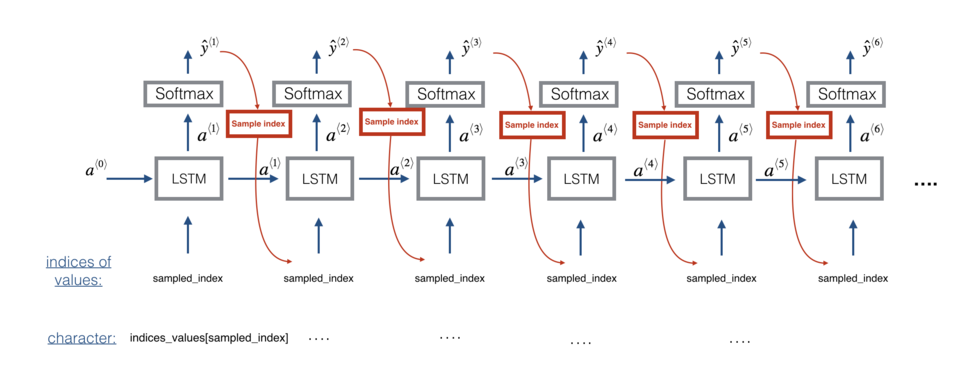

① 在采样的每个步骤中，你将以LSTM先前状态的激活“a”和单元状态“c”作为输入，向前传播一步，并获得新的输出激活以及单元状态。

② 然后，和之前一样使用densor通过新的激活a来生成输出。

③ 首先，我们将初始化x0以及LSTM激活，并将单元值a0和c0初始化为零。

④ 你将要构建一个函数来为你进行此推断。

⑤ 你的函数将采用你先前的模型以及你要采样的时间步长“Ty”。

⑥ 它将返回一个可以为你生成序列的keras模型。

⑦ 此外，该函数包含78个单位的密集层和激活函数。

① 练习：实现以下函数以采样一系列音乐值。

② 这是在for循环内生成$T_y$输出字符需要实现的一些关键步骤：

 - 步骤2.A：使用LSTM_Cell，它输入上一步的“c”和“a”来生成当前步骤的“c”和“a”。
 - 步骤2.B：使用densor（先前定义）在“a”上计算softmax，以获取当前步骤的输出。
 - 步骤2.C：将刚刚生成的输出添加到outputs中并保存。
 - 步骤2.D：将x采样为“out”的独热向量（预测），以便将其传递到下一个LSTM步骤。我们已经提供了这行代码，其中使用了Lambda 函数。
    - x = Lambda(one_hot)(out)
    - 说明：这行代码实际上不是使用out中的概率对值进行随机采样，而是在每个步骤中使用argmax选择最可能的一个值。

In [10]:
def music_inference_model(LSTM_cell, densor, n_values = 78, n_a = 64, Ty = 100):
    """
    参数：
        LSTM_cell -- 来自model()的训练过后的LSTM单元，是keras层对象。
        densor -- 来自model()的训练过后的"densor"，是keras层对象
        n_values -- 整数，唯一值的数量
        n_a -- LSTM单元的数量
        Ty -- 整数，生成的是时间步的数量
        
    返回：
        inference_model -- Kears模型实体
    """
    
    # 定义模型输入的维度
    x0 = Input(shape=(1,n_values))
    
    # 定义s0，初始化隐藏状态
    a0 = Input(shape=(n_a,),name="a0")
    c0 = Input(shape=(n_a,),name="c0")
    a = a0
    c = c0
    x = x0
    
    # 步骤1：创建一个空的outputs列表来保存预测值。
    outputs = []
    
    # 步骤2：遍历Ty，生成所有时间步的输出
    for t in range(Ty):
        
        # 步骤2.A：在LSTM中单步传播
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # 步骤2.B：使用densor()应用于LSTM_Cell的隐藏状态输出
        out = densor(a)
        
        # 步骤2.C：预测值添加到"outputs"列表中
        outputs.append(out)
        
        # 根据“out”选择下一个值，并将“x”设置为所选值的一个独热编码，
        # 该值将在下一步作为输入传递给LSTM_cell。我们已经提供了执行此操作所需的代码
        x = Lambda(one_hot)(out)
        
    # 创建模型实体
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    return inference_model

③ 运行下面的单元格以定义你的模型。该模型经过硬编码以生成50个值。

In [11]:
# 获取模型实体，模型被硬编码以产生50个值
inference_model = music_inference_model(LSTM_cell, densor, n_values = 78, n_a = 64, Ty = 50)

④ 最后，创建零向量，你将使用它们初始化x和LSTM状态变量a和c。

In [12]:
#创建用于初始化x和LSTM状态变量a和c的零向量。
x_initializer = np.zeros((1, 1, 78))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

① 练习：实现predict_and_sample()。

② 此函数接受许多参数，包括输入[x_initializer, a_initializer, c_initializer]。

③ 为了预测与此输入相对应的输出，你将需要执行3个步骤：
 1. 根据你的输入集，使用模型预测输出。输出pred应该是长度为20的列表，其中每个元素都是一个形状为($T_y$, n_values)的numpy数组。
 2. 将pred转换为$T_y$索引的numpy数组。通过使用pred列表中元素的argmax来计算每个对应的索引。
 3. 将索引转换为独热向量表示。

In [13]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    使用模型预测当前值的下一个值。
    
    参数：
        inference_model -- keras的实体模型
        x_initializer -- 初始化的独热编码，维度为(1, 1, 78)
        a_initializer -- LSTM单元的隐藏状态初始化，维度为(1, n_a)
        c_initializer -- LSTM单元的状态初始化，维度为(1, n_a)
    
    返回：
        results -- 生成值的独热编码向量，维度为(Ty, 78)
        indices -- 所生成值的索引矩阵，维度为(Ty, 1)
    """
    # 步骤1：模型来预测给定x_initializer, a_initializer and c_initializer的输出序列
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    
    # 步骤2：将“pred”转换为具有最大概率的索引数组np.array()。
    indices = np.argmax(pred, axis=-1)
    
    # 步骤3：将索引转换为它们的一个独热编码。
    results = to_categorical(indices, num_classes=78)
    
    return results, indices

① 由于Keras的结果并非完全可预测，因此你的结果可能会有所不同。

② 但是，如果你如上所述用model.fit()将LSTM_cell训练了正好100次迭代，那么你很有可能会观察到一系列不完全相同的索引。

③ 此外，你应该注意：np.argmax（results [12]）是list（indices [12:18]）的第一个元素，np.argmax（results [17]）是list（indices[12:18]的最后一个元素）。

In [14]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)
print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

np.argmax(results[12]) = 39
np.argmax(results[17]) = 53
list(indices[12:18]) = [array([39], dtype=int64), array([9], dtype=int64), array([22], dtype=int64), array([5], dtype=int64), array([37], dtype=int64), array([53], dtype=int64)]


## 4.2 生成音乐

① 最后，你准备好生成音乐了。你的RNN会生成一个值序列。

② 以下代码首先通过调用你的predict_and_sample()函数来生成音乐。然后，将这些值后期处理为和弦（意味着可以同时演奏多个值或音符）。

③ 大多数计算音乐算法都使用某些后期处理，因为没有这种后期处理很难生成听起来不错的音乐。

④ 后期处理通过诸如确保相同的声音不会重复太多，两个连续的音符彼此之间的音高相距不远等来处理生成的音频。

⑤ 可能有人争辩说，这些后期处理步骤中有很多都是黑客。

⑥ 同样，很多音乐生成文学也集中于手工制作后处理器，并且许多输出质量取决于后期处理的质量，而不仅仅是RNN的质量。

⑦ 但是这种后期处理的确有很大的不同，因此在我们的实现中也试着使用它。

⑧ 让我们开始尝试制作音乐吧！

① 运行以下单元格来生成音乐并将其记录到你的out_stream中。这可能需要几分钟。

In [15]:
out_stream = generate_music(inference_model)

Predicting new values for different set of chords.
Generated 51 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 49 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 50 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


② 要试听音乐，请单击File->Open...，然后转到"output/" 并下载 "my_music.midi"。

③ 你可以使用可读取Midi文件的应用程序在计算机上播放该文件，也可以使用免费在线转换工具"MIDI to mp3"将其转换为mp3。

In [16]:
IPython.display.Audio('./datasets/30s_trained_model.mp3')

① 恭喜！你已经到了此笔记本的结尾部分。

② 这是你应该记住的：

 - 序列模型可用于生成音乐值，然后将其后处理为Midi音乐。
 - 可以使用非常相似的模型来生成恐龙名称或生成音乐，主要区别是模型的输入。
 - 在Keras中，序列生成包括定义具有共享权重的网络层，然后在不同的时间步$1, \ldots, T_x$中重复这些步骤。
 
③ 最后恭喜你完成此任务并创作了一首爵士小歌！